In [1]:
import duckdb
import pandas as pd

# No need to import duckdb_engine
#  jupysql will auto-detect the driver needed based on the connection string!

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [7]:
%%sql success_fail << 
SELECT 
    ValueInt as count, 
    Attributes['path'][1] as path, 
    Attributes['result'][1] as result,
    
FROM 'metrics.parquet' 
WHERE
    Name = 'goose_requests_total'
    AND Attributes['mode'][1] = 'manager'

In [8]:
pivoted = success_fail.pivot(index='path', columns='result', values='count')

ratios = pivoted.apply(lambda r: {'Percentage of Successful Requests': 100.0 * r.success / (r.success + r.fail)}, axis=1, result_type='expand').rename_axis('path').reset_index()
ratios

,path,Percentage of Successful Requests
0,check,100.000000
1,dag_get,99.945936
2,dag_put,100.000000


In [9]:
%%sql percentiles <<
SELECT 
    ValueDouble as duration, 
    Attributes['path'][1] as path,
    Attributes['percentile'][1] as percentile 
FROM './metrics.parquet' 
WHERE 
    Name = 'goose_requests_duration_percentiles' 
    AND Attributes['mode'][1] = 'manager' 
ORDER BY percentile

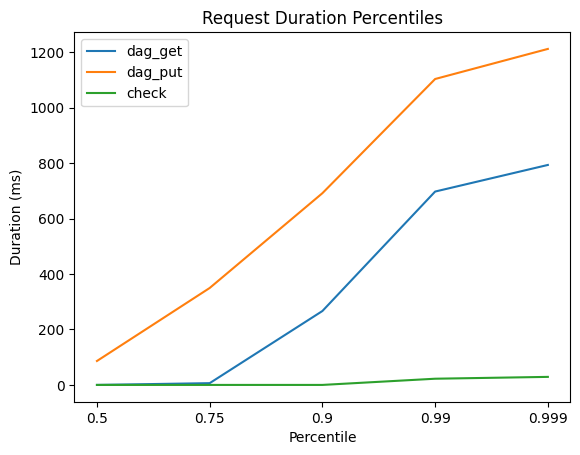

In [10]:
from matplotlib import pyplot as plt

paths = set()
for path in percentiles.path:
    paths.add(path)
    
for path in paths:
    plt.plot('percentile', 'duration', data=percentiles.loc[percentiles.path == path], label=path)

plt.title('Request Duration Percentiles')
plt.xlabel('Percentile')
plt.ylabel('Duration (ms)')
plt.legend(loc='upper left')